В цьому домашньому завданні ми побудуємо рішення задачі логістичної регресії і створимо ваш перший submission на змагання на Kaggle. Усі кроки були розглянуті в лекції та містяться в ноутбуці `Логістична регресія з ScikitLearn. Повна ML задача.ipynb`, але тепер ми їх адаптуємо до іншої задачі - все як в реальному житті, коли ви знайшли код у відкритих джерелах і адаптуєте на проєкті 😉

**Погнали! 🚀🚀🚀**

-----------



0. Завантажте дані `train.csv`, `test.csv`, `sample_submission.csv` зі змагання на Kaggle ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0). Для завантаження потрібно долучитись до змагання (натиснути кнопку "Join").

1. Зчитайте дані `train.csv` в pandas dataframe та розбийте їх на train і validation піднабори.

  * Є такий параметр в методі train_test_split як stratified. Можливо він буде Вам корисним при розбитті даних в цій задачі. Пропоную Вам почитати про нього в документації і спробувати скористатись.

In [1]:
import opendatasets as od
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc

import joblib

In [2]:
dataset_url = 'https://www.kaggle.com/competitions/bank-customer-churn-prediction-dlu/data'

In [3]:
od.download(dataset_url)

Skipping, found downloaded files in "./bank-customer-churn-prediction-dlu" (use force=True to force download)


In [4]:
data_dir = './bank-customer-churn-prediction-dlu'

In [5]:
os.listdir(data_dir)

['test.csv', 'train.csv', 'sample_submission.csv']

In [6]:
train_csv = data_dir + '/train.csv'

In [7]:
main_df = pd.read_csv(train_csv)

In [8]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15000 entries, 0 to 14999
Data columns (total 14 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   id               15000 non-null  int64  
 1   CustomerId       15000 non-null  float64
 2   Surname          15000 non-null  object 
 3   CreditScore      15000 non-null  float64
 4   Geography        15000 non-null  object 
 5   Gender           15000 non-null  object 
 6   Age              15000 non-null  float64
 7   Tenure           15000 non-null  float64
 8   Balance          15000 non-null  float64
 9   NumOfProducts    15000 non-null  float64
 10  HasCrCard        15000 non-null  float64
 11  IsActiveMember   15000 non-null  float64
 12  EstimatedSalary  15000 non-null  float64
 13  Exited           15000 non-null  float64
dtypes: float64(10), int64(1), object(3)
memory usage: 1.6+ MB


In [9]:
target_col = 'Exited'

In [10]:
train_val_df, test_df = train_test_split(main_df, test_size=0.2, random_state=42, stratify=main_df[target_col])
train_df, val_df = train_test_split(train_val_df, test_size=0.25, random_state=42, stratify=train_val_df[target_col])

In [11]:
print('train_df.shape :', train_df.shape)
print('val_df.shape :', val_df.shape)
print('test_df.shape :', test_df.shape)

train_df.shape : (9000, 14)
val_df.shape : (3000, 14)
test_df.shape : (3000, 14)


2. Визначіть назви колонок, які сформують вхідні незалежні дані, в змінній `input_cols` та назву колонки , яка є цільовою, в змінній `target_col`. Використовуючи `input_cols` та `target_col` створіть набори даних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` - де `inputs` - вхідні дані (датафрейм), `targets` - дані цільової колонки відповідного піднабору.

In [12]:
target_col = 'Exited'
input_data = main_df.drop(columns=[target_col])
input_col = list(input_data.columns)

In [13]:
train_inputs = train_df[input_col].copy()
train_targets = train_df[target_col].copy()

val_inputs = val_df[input_col].copy()
val_targets = val_df[target_col].copy()

test_inputs= test_df[input_col].copy()
test_targets = test_df[target_col].copy()


3. Визначіть з допомогою `pandas.DataFrame.select_dtypes` назви колонок, які є числовими і категоріальними. Запишіть результати в `numeric_cols` та `categorical_cols` відповідно.

In [14]:
numeric_cols = train_inputs.select_dtypes(include='number').columns.tolist()
categorical_cols = train_inputs.select_dtypes(include='object').columns.tolist()

4. Зробіть підготовку даних в категоріальних і числових колонках для входу в модель виходячи з освоєного на даний момент на курсі. Варіанти пеердобробки, з якими ми вже знайомі:
  - масштабування числових ознак,
  - заповнення пропущених значень, якщо вони є,
  - кодування категоріальних ознак, вилучення ознак, якщо ми вважаємо, що ці дані нерелевантні для моделі аби ми не бачимо способу як їх так закодувати, аби подати на вхід моделі.

  Тут є багато варіантів, як Ви побудуєте передобробку, важливо аби
  1) передобробка мала сенс (немає сенсу заповнювати дані константою, яку ми не зрозуміло звідки взяли)   
  2) має бути виконана принаймні одна дія передобробки
  3) обробка маэ бути виконана коректно і для тренувальних, і для вал. даних
  4) чим вищий у Вас врешті вийде ROС AUC скор, тим більше шансів перемогти у змаганні :)

  Опишіть рішення проведення кожного з кроків передобробки. Для чого ви його робите? По завершенню виведіть по 5 значен з `train_inputs`, `val_inputs` використовуючи `display()`.

Перевіримо, що за числові дані ми маємо

In [15]:
train_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00,9000.00
mean,7482.28,15690767.13,658.58,37.68,5.02,43029.89,1.59,0.79,0.49,117966.92
std,4324.22,164691.23,72.00,8.12,2.78,59826.88,0.53,0.41,0.50,45719.05
min,0.00,1581102.00,431.00,18.00,0.00,0.00,1.00,0.00,0.00,11.58
25%,3726.50,15635141.00,603.00,32.00,3.00,0.00,1.00,1.00,0.00,83092.52
50%,7471.50,15690000.50,661.00,37.00,5.00,0.00,2.00,1.00,0.00,123542.16
75%,11229.25,15756921.50,708.00,42.00,7.00,109735.03,2.00,1.00,1.00,157097.09
max,14997.00,15815690.00,850.00,72.00,10.00,209767.31,4.00,1.00,1.00,199992.48


In [16]:
val_inputs[numeric_cols].describe().round(2)

,id,CustomerId,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
count,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.00,3000.0,3000.00
mean,7471.68,15691394.57,659.64,37.72,5.05,42943.04,1.59,0.79,0.5,118068.84
std,4364.26,70628.99,73.34,8.19,2.80,60155.19,0.53,0.41,0.5,45206.06
min,4.00,15566292.00,437.00,19.00,0.00,0.00,1.00,0.00,0.0,11.58
25%,3722.00,15634574.25,602.00,32.00,3.00,0.00,1.00,1.00,0.0,83457.67
50%,7473.00,15689504.50,663.00,37.00,5.00,0.00,2.00,1.00,0.0,123961.89
75%,11237.75,15756907.25,710.00,42.00,7.00,111071.31,2.00,1.00,1.0,155876.94
max,14999.00,15815236.00,850.00,74.00,10.00,187841.99,4.00,1.00,1.0,199805.63


Маємо колонку коду клієнта  і ID, яка не буде впливати на прогнозування, її краще прибрати з дата фрейму перед маштабуванням і тренуванням моделі

In [17]:
numeric_cols.remove('id')
numeric_cols.remove('CustomerId')

Також бачу дуже занизьке значення мін в колонці заробітньої платии, перевіримо додатково, які це за значення, можливо видалимо їх, як викиди

In [18]:
train_inputs[train_inputs['EstimatedSalary'] < 100]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
12856,12856,15660211.0,Okeke,661.0,France,Male,36.0,2.0,122924.75,1.0,1.0,0.0,11.58


In [19]:
val_inputs[val_inputs['EstimatedSalary'] < 100]

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
7232,7232,15651460.0,Milanesi,718.0,Germany,Female,35.0,8.0,123953.31,1.0,1.0,0.0,11.58


In [20]:
rows_to_drop_train = train_inputs[train_inputs['EstimatedSalary'] < 100].index
rows_to_drop_val = val_inputs[val_inputs['EstimatedSalary'] < 100].index

train_inputs = train_inputs.drop(rows_to_drop_train)
train_targets = train_targets.drop(rows_to_drop_train)

val_inputs = val_inputs.drop(rows_to_drop_val)
val_targets = val_targets.drop(rows_to_drop_val)

пустих значень ми не маємо , тому переходимо до маштабування числових даних, для поліпшення розрахунку регресії і побудови градієнтного спуску 

In [21]:
scaler = MinMaxScaler()

In [22]:
scaler.fit(train_inputs[numeric_cols])

MinMaxScaler()

In [23]:
train_inputs[numeric_cols] = scaler.transform(train_inputs[numeric_cols])
val_inputs[numeric_cols] = scaler.transform(val_inputs[numeric_cols])
#test_inputs[numeric_cols] = scaler.transform(test_inputs[numeric_cols])

перейдемо до категоріальних колонок

In [24]:
train_inputs[categorical_cols].nunique()

Surname      688
Geography      3
Gender         2
dtype: int64

In [25]:
train_inputs.Geography.unique()

array(['France', 'Spain', 'Germany'], dtype=object)

In [26]:
train_inputs.Gender.unique()

array(['Male', 'Female'], dtype=object)

маємо три категоріальні колонки, одна з яких - прізвище, яка має дотатньо велику к-ть унікальних значень і не вплине на наші розрахунки, тому спробуємо її видалити

In [27]:
categorical_cols.remove('Surname')

Створюємо енкодер з умовою видалення першої колонки, для покращення розрахунку 

In [28]:
encoder = OneHotEncoder(drop='first',sparse_output=False, handle_unknown='ignore')

In [29]:
encoder.fit(train_inputs[categorical_cols])

OneHotEncoder(drop='first', handle_unknown='ignore', sparse_output=False)

In [30]:
encoder.categories_

[array(['France', 'Germany', 'Spain'], dtype=object),
 array(['Female', 'Male'], dtype=object)]

In [31]:
encoded_cols = list(encoder.get_feature_names_out(categorical_cols))
print(encoded_cols)

['Geography_Germany', 'Geography_Spain', 'Gender_Male']


In [32]:
train_inputs[encoded_cols] = encoder.transform(train_inputs[categorical_cols])
val_inputs[encoded_cols] = encoder.transform(val_inputs[categorical_cols])
#test_inputs[encoded_cols] = encoder.transform(test_inputs[categorical_cols])

перевіримо кінцевий результат 

In [33]:
display(train_inputs.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
63,63,15771483.0,Fomin,0.744630,France,Male,0.333333,0.5,0.000000,0.333333,0.0,1.0,0.448250,0.0,0.0,1.0
13717,13717,15591135.0,Pirozzi,0.420048,France,Male,0.314815,0.6,0.000000,0.333333,1.0,1.0,0.763168,0.0,0.0,1.0
13292,13292,15572767.0,Chukwudi,0.821002,France,Female,0.277778,0.6,0.578527,0.000000,1.0,0.0,0.705128,0.0,0.0,0.0
9615,9615,15648800.0,Chukwubuikem,0.369928,Spain,Male,0.555556,0.1,0.000000,0.000000,0.0,1.0,0.749199,0.0,1.0,1.0
1618,1618,15746338.0,Chin,0.665871,France,Male,0.259259,0.5,0.000000,0.333333,1.0,0.0,0.340537,0.0,0.0,1.0


In [34]:
display(val_inputs.head())

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male
4434,4434,15717191.0,McLean,0.305489,France,Male,0.407407,0.7,0.637030,0.000000,0.0,1.0,0.922770,0.0,0.0,1.0
8707,8707,15751203.0,L?,0.742243,France,Male,0.296296,0.7,0.000000,0.333333,0.0,1.0,0.831242,0.0,0.0,1.0
679,679,15595427.0,Ch'in,0.816229,France,Male,0.296296,0.7,0.000000,0.333333,1.0,0.0,0.468844,0.0,0.0,1.0
4765,4765,15662736.0,Yudin,0.400955,France,Male,0.388889,0.4,0.000000,0.333333,1.0,1.0,0.633186,0.0,0.0,1.0
9354,9354,15801125.0,Y?an,0.656325,Germany,Female,0.388889,0.9,0.475355,0.333333,1.0,1.0,0.651266,1.0,0.0,0.0


In [35]:
#display(test_inputs.head())

5. Збережіть дані, що містяться в змінних `train_inputs`, `train_targets`, `val_inputs`, `val_targets` на диск в форматі `parquet`. В кінці виведіть список файлів в папці, в яку Ви зберегли файли і перевірте, чи файли збереглись. Вивести список файлів можна з `os.listdir(your_dir)` або `!ls your_dir`

In [36]:
print('train_inputs:', train_inputs.shape)
print('train_targets:', train_targets.shape)
print('val_inputs:', val_inputs.shape)
print('val_targets:', val_targets.shape)
print('test_inputs:', test_inputs.shape)
print('test_targets:', test_targets.shape)

train_inputs: (8999, 16)
train_targets: (8999,)
val_inputs: (2999, 16)
val_targets: (2999,)
test_inputs: (3000, 13)
test_targets: (3000,)


In [37]:
train_inputs.to_parquet('train_inputs.parquet')
val_inputs.to_parquet('val_inputs.parquet')
test_inputs.to_parquet('test_inputs.parquet')

In [38]:
%%time
pd.DataFrame(train_targets).to_parquet('train_targets.parquet')
pd.DataFrame(val_targets).to_parquet('val_targets.parquet')
pd.DataFrame(test_targets).to_parquet('test_targets.parquet')

CPU times: user 2.83 ms, sys: 1.47 ms, total: 4.3 ms
Wall time: 4.83 ms


In [39]:
# %%time

# train_inputs = pd.read_parquet('train_inputs.parquet')
# val_inputs = pd.read_parquet('val_inputs.parquet')
# test_inputs = pd.read_parquet('test_inputs.parquet')

# train_targets = pd.read_parquet('train_targets.parquet')[target_col]
# val_targets = pd.read_parquet('val_targets.parquet')[target_col]
# test_targets = pd.read_parquet('test_targets.parquet')[target_col]

In [40]:
# print('train_inputs:', train_inputs.shape)
# print('train_targets:', train_targets.shape)
# print('val_inputs:', val_inputs.shape)
# print('val_targets:', val_targets.shape)
# print('test_inputs:', test_inputs.shape)
# print('test_targets:', test_targets.shape)

In [41]:
#val_targets,val_inputs

6. З підготовлених вхіжних даних створіть `X_train`, `X_val` набори, які містять лише колонки, які підуть на вхід моделі. Навчіть модель бінарної класифікації з допомогою `LogisticRegression` в `scikit-learn`.

In [42]:
columns_for_model = numeric_cols + encoded_cols
columns_for_model

['CreditScore',
 'Age',
 'Tenure',
 'Balance',
 'NumOfProducts',
 'HasCrCard',
 'IsActiveMember',
 'EstimatedSalary',
 'Geography_Germany',
 'Geography_Spain',
 'Gender_Male']

In [43]:
X_train = train_inputs[columns_for_model]
y_train = train_targets
X_val = val_inputs[columns_for_model]
y_val = val_targets
#X_test = test_inputs[columns_for_model]
#y_test = test_targets

In [44]:
model = LogisticRegression(solver='liblinear')

In [45]:
model.fit(X_train,y_train)

LogisticRegression(solver='liblinear')

In [46]:
model.coef_.round(2)

array([[-0.89,  8.23, -0.08, -1.08, -3.79, -0.18, -1.25,  0.3 ,  1.58,
        -0.19, -0.85]])

In [47]:
print(model.intercept_)

[-2.74264013]


In [48]:
train_preds = model.predict(X_train)
val_preds = model.predict(X_val)
train_preds, val_preds

(array([0., 0., 0., ..., 0., 0., 0.]), array([0., 0., 0., ..., 0., 0., 0.]))

In [49]:
train_probs = model.predict_proba(X_train)
val_probs = model.predict_proba(X_val)
train_probs, val_probs

(array([[0.98098271, 0.01901729],
        [0.9800947 , 0.0199053 ],
        [0.8615977 , 0.1384023 ],
        ...,
        [0.89746551, 0.10253449],
        [0.87630217, 0.12369783],
        [0.86211368, 0.13788632]]),
 array([[0.90370045, 0.09629955],
        [0.98446352, 0.01553648],
        [0.96252938, 0.03747062],
        ...,
        [0.94604501, 0.05395499],
        [0.94719894, 0.05280106],
        [0.52248964, 0.47751036]]))

In [50]:
y_train.value_counts(normalize=True)

Exited
0.0    0.796533
1.0    0.203467
Name: proportion, dtype: float64

In [51]:
train_probs[train_probs[:,1] > 0.5].shape

(1247, 2)

In [52]:
y_val.value_counts(normalize=True)

Exited
0.0    0.796599
1.0    0.203401
Name: proportion, dtype: float64

In [53]:
val_probs[val_probs[:,1] > 0.5].shape

(441, 2)

(array([4751., 1436.,  686.,  492.,  375.,  285.,  227.,  237.,  275.,
         235.]),
 array([0.0014556 , 0.100606  , 0.1997564 , 0.2989068 , 0.39805721,
        0.49720761, 0.59635801, 0.69550841, 0.79465881, 0.89380922,
        0.99295962]),
 <BarContainer object of 10 artists>)

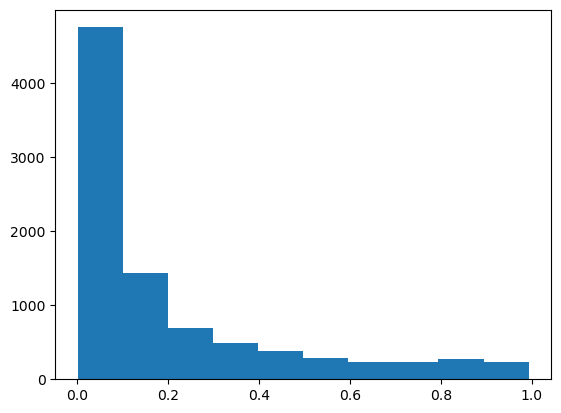

In [54]:
plt.hist(train_probs[:,1])

(array([1585.,  491.,  223.,  145.,  111.,  114.,   79.,   85.,   83.,
          83.]),
 array([0.00153631, 0.10022724, 0.19891818, 0.29760911, 0.39630004,
        0.49499098, 0.59368191, 0.69237285, 0.79106378, 0.88975471,
        0.98844565]),
 <BarContainer object of 10 artists>)

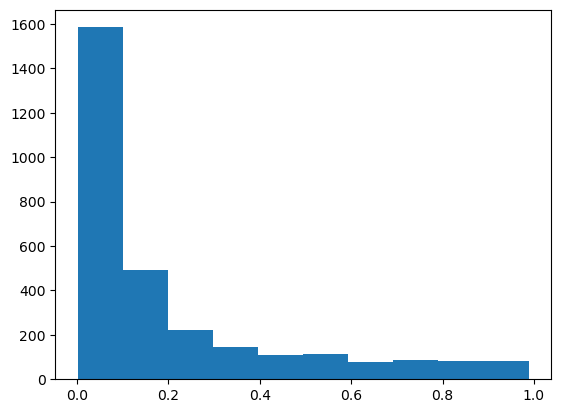

In [55]:
plt.hist(val_probs[:,1])

In [56]:
accuracy_score(y_train, train_preds)

0.8733192576952995

In [57]:
accuracy_score(y_val, val_preds)

0.871623874624875

Акуратність наборів данних сходиться, що може свідчити про добре натреновану модель

7. Виведіть Confusion matrix, ROC Curve, метрику AUROC та метрику F1 Score для порога класифікації 0.5 для побудованої моделі на тренувальних та валідаційних даних. Що можете сказати про якіст моделі? Вона хороша, погана, задовільна?

In [58]:
cm_train = confusion_matrix(y_train, train_preds, normalize='true')
cm_val = confusion_matrix(y_val, val_preds, normalize='true')
print('CM score train df:\n', cm_train)
print('CM score val df:\n', cm_val)

CM score train df:
 [[0.96121652 0.03878348]
 [0.47078099 0.52921901]]
CM score val df:
 [[0.9547928  0.0452072 ]
 [0.45409836 0.54590164]]


Бачимо, що в нас великий відсоток значень помилки 2 роду (FN)

In [59]:
def get_f1_score(inputs, targets, name=''):
  preds = model.predict(inputs)

  f1_score_ = f1_score(targets, preds, pos_label=1.0)
  print(f"F1 score {name}: {f1_score_:.2f}%")

get_f1_score(X_train, y_train, 'Training')
get_f1_score(X_val, y_val, 'Validation')
#get_f1_score(X_test, y_test, 'Test')

F1 score Training: 0.63%
F1 score Validation: 0.63%


модель працює гарно на обох наборах даних, що є хорошим результатом

AUROC for Training: 0.88


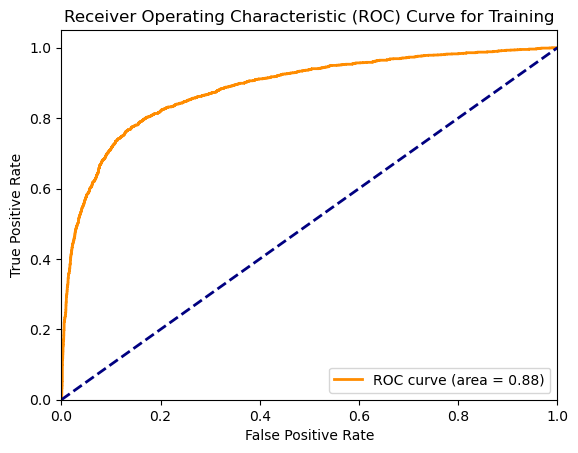

AUROC for Validation: 0.88


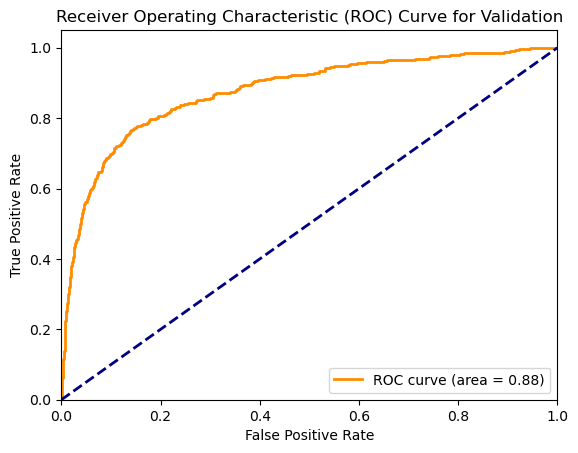

In [60]:
from sklearn.metrics import roc_curve, auc

def compute_auroc_and_build_roc(inputs, targets, targets_probs, name=''):
  
  # Compute ROC curve
  fpr, tpr, thresholds = roc_curve(targets, targets_probs, pos_label=1.0)
  

  # Compute AUROC
  roc_auc = auc(fpr, tpr)
  print(f'AUROC for {name}: {roc_auc:.2f}')

  # Plot the ROC curve
  plt.figure()
  plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
  plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
  plt.xlim([0.0, 1.0])
  plt.ylim([0.0, 1.05])
  plt.xlabel('False Positive Rate')
  plt.ylabel('True Positive Rate')
  plt.title(f'Receiver Operating Characteristic (ROC) Curve for {name}')
  plt.legend(loc="lower right")
  plt.show()

compute_auroc_and_build_roc(X_train, y_train, train_probs[:, 1], 'Training')
compute_auroc_and_build_roc(X_val, y_val, val_probs[:, 1], 'Validation')

по результатам бачимо, AUROC for Validation: 0.79, що може свідчити, що в нас хороший класифікатор 

8. Створіть передбачення моделі, яка передбачає завжди мажоритарний клас (той, якого більше в тренувальних даних). Порахуйте Accuracy на тренувальних та валідаційних даних для цієї моделі і тої, що ми натренували в п.6. Зробіть заключення про якість нашої моделі: якість хороша, погана, задовільна?

In [61]:
majority_class = y_train.mode()[0]
majority_class

0.0

In [62]:
train_predictions_majority = [majority_class] * len(X_train)
val_predictions_majority = [majority_class] * len(X_val)

In [63]:
accuracy_score(y_train, train_predictions_majority)

0.796532948105345

In [64]:
accuracy_score(y_val, val_predictions_majority)

0.796598866288763

Маємо не погане значення акуратності, але це всьго лиш частоту мажоритарного класу у вибірці, воно нижче ніж акуратність моделі лінійної регресії, що свідчить про те що модель лінійної регресії брати краще ніж цю, так як вона враховує залежності між ознаками


9. Збережіть модель і інші обʼєкти, які ви хотіли б зберегти, з використанням бібліотеки joblib в файл `log_reg.joblib`. Потім завантажте модель з файлу в змінну `model_2` (цим ми тренуємось завантажувати модель з файлу на майбутнє).

In [65]:
bank_customer = {
    'model': model,
    'scaler': scaler,
    'encoder': encoder,
    'input_cols': input_col,
    'target_col': target_col,
    'numeric_cols': numeric_cols,
    'categorical_cols': categorical_cols,
    'encoded_cols': encoded_cols,
    'columns_for_model': columns_for_model
}

In [66]:
joblib.dump(bank_customer, 'log_reg.joblib')

['log_reg.joblib']

In [67]:
bank_customer_2 = joblib.load('log_reg.joblib')

10. Ознайомтесь з роботою наведеної функції `predict_raw_df`. Ця функція робить підготовку даних (масштабування числових колонок і кодування категоріальних) і виводить ймовірності належності до класу 1 для кожного рядка в наданому наборі.

Доповніть або внесіть зміни у функцію з врахуванням вашого препроцесингу даних.

In [68]:
import warnings
warnings.filterwarnings("ignore")

def predict_df(scaler, encoder, numeric_cols, categorical_cols, input_df: pd.DataFrame):
    input_df[numeric_cols] = scaler.transform(input_df[numeric_cols])
    input_df[encoded_cols] = encoder.transform(input_df[categorical_cols])
    X_input = input_df[numeric_cols + encoded_cols]
    prob = model.predict_proba(X_input)[:,1]

    return prob

In [69]:
main_pred_proba = predict_df(scaler, encoder, numeric_cols, categorical_cols, main_df)
main_pred_proba

array([0.0072737 , 0.03624026, 0.39895805, ..., 0.90266228, 0.19075011,
       0.10798666])

In [70]:
main_targets = main_df['Exited']

AUROC for Main: 0.88


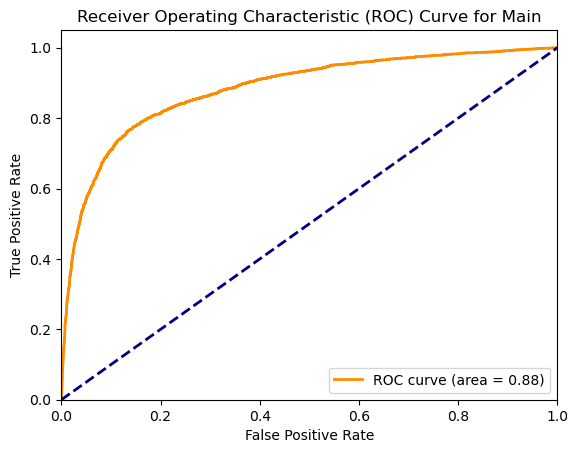

In [71]:
compute_auroc_and_build_roc(main_df, main_targets, main_pred_proba, 'Main')

11. Зчитайте дані з `test.csv` в змінну `test_raw_df`. Зробіть передбачення для кожного рядка даних з функцією з попереднього завдання і запишіть результат в нову колонку `Exited` в датафреймі `test_raw_df`.

In [72]:
test_bank_df = pd.read_csv(data_dir + '/test.csv')

In [73]:
test_bank_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary
0,15000,15594796.0,Chu,584.0,Germany,Male,30.0,2.0,146053.66,1.0,1.0,1.0,157891.86
1,15001,15642821.0,Mazzi,551.0,France,Male,39.0,5.0,0.00,2.0,1.0,1.0,67431.28
2,15002,15716284.0,Onyekachi,706.0,France,Male,43.0,8.0,0.00,2.0,1.0,0.0,156768.45
3,15003,15785078.0,Martin,717.0,Spain,Male,45.0,3.0,0.00,1.0,1.0,1.0,166909.87
4,15004,15662955.0,Kenechukwu,592.0,Spain,Male,43.0,8.0,0.00,2.0,1.0,1.0,143681.97


In [74]:
test_bank_df['Exited'] = predict_df(scaler, encoder, numeric_cols, categorical_cols, test_bank_df)

test_bank_df.head()

,id,CustomerId,Surname,CreditScore,Geography,Gender,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_Germany,Geography_Spain,Gender_Male,Exited
0,15000,15594796.0,Chu,0.365155,Germany,Male,0.222222,0.2,0.696265,0.000000,1.0,1.0,0.789017,1.0,0.0,1.0,0.078149
1,15001,15642821.0,Mazzi,0.286396,France,Male,0.388889,0.5,0.000000,0.333333,1.0,1.0,0.335682,0.0,0.0,1.0,0.036031
2,15002,15716284.0,Onyekachi,0.656325,France,Male,0.462963,0.8,0.000000,0.333333,1.0,0.0,0.783387,0.0,0.0,1.0,0.161504
3,15003,15785078.0,Martin,0.682578,Spain,Male,0.500000,0.3,0.000000,0.000000,1.0,1.0,0.834210,0.0,1.0,1.0,0.184006
4,15004,15662955.0,Kenechukwu,0.384248,Spain,Male,0.462963,0.8,0.000000,0.333333,1.0,1.0,0.717805,0.0,1.0,1.0,0.053645


12. Зчитайте файл 'sample_submission.csv' і зповніть колонку `Exited` передбаченими вашою моделлю значеннями для кожного відповідного `id` клієнта.
Виведіть перші 5 рядків фінального датасету, збережіть результат в файл `submission_log_reg.csv` (УВАГА! не запишіть випадково ще індекси рядків!) і здайте цей файл на Kaggle зі свого профіля натиснувши `Submit Prediction`.

In [75]:
sample_submission_df = pd.read_csv(data_dir + '/sample_submission.csv')

In [76]:
sample_submission_df.head()

,id,Exited
0,15000,0.5
1,15001,0.5
2,15002,0.5
3,15003,0.5
4,15004,0.5


In [81]:
sample_submission_df['Exited'] = test_bank_df['Exited'].round(2)
sample_submission_df.head()

,id,Exited
0,15000,0.08
1,15001,0.04
2,15002,0.16
3,15003,0.18
4,15004,0.05


In [82]:

sample_submission_df.to_csv('submission_log_reg.csv', index=False)